# Generate Member Anomalies S2S

---

Uses the climatology generated in `2_generate_model_climatology.ipynb` to create anomalies from the S2S forecasting system.

In [1]:
import xarray as xr
xr.set_options(keep_attrs=True)
import glob
import cftime

from dask.distributed import Client

In [2]:
client = Client("tcp://10.12.206.54:41456")

Choose your model

In [3]:
model = "ECCC" #ECMWF, NCEP, or ECCC

In [4]:
raw = xr.open_zarr("/glade/campaign/mmm/c3we/jaye/S2S_zarr/"+model+".raw.daily.geospatial.zarr/",consolidated=True)
clim = xr.open_zarr("/glade/campaign/mmm/c3we/jaye/S2S_zarr/"+model+".climatology.daily.geospatial.zarr/",consolidated=True)

Here we want to compute the climatology before creating the anomalies so the calculation is more efficient.

In [5]:
%time clim = clim.compute()

CPU times: user 4.26 s, sys: 31.7 s, total: 36 s
Wall time: 2min 20s


# Calculate anomalies!

In [6]:
raw = raw.chunk({"member": -1, "init": 1, "lead": -1, "lat": 121, "lon": 240}).persist()
ds_anom = raw.groupby("init.dayofyear") - clim

In [7]:
ds_anom

,Array,Chunk
Bytes,31.52 GB,29.74 MB
Shape,"(4, 1060, 32, 121, 240)","(4, 1, 32, 121, 240)"
Count,5397 Tasks,1060 Chunks
Type,float64,numpy.ndarray
,Array,Chunk
Bytes,31.52 GB,29.74 MB
Shape,"(4, 1060, 32, 121, 240)","(4, 1, 32, 121, 240)"
Count,5397 Tasks,1060 Chunks
Type,float64,numpy.ndarray
,Array,Chunk


Convert the `init` dimension to a proleptic gregorian calendar using cftime.

In [8]:
ds_anom["init"] = [cftime.DatetimeProlepticGregorian(int(str(d)[0:4]), int(str(d)[5:7]), int(str(d)[8:10])) for d in ds_anom["init"].values]

# Write the anomalies out to a zarr file!

In [9]:
%time ds_anom.to_zarr("/glade/campaign/mmm/c3we/jaye/S2S_zarr/"+model+".anom.daily.geospatial.zarr/",mode="w",consolidated=True)

CPU times: user 3 s, sys: 11.9 s, total: 14.9 s
Wall time: 1min 39s


Just made a quick plot to check that they are anomalies. Looks good!

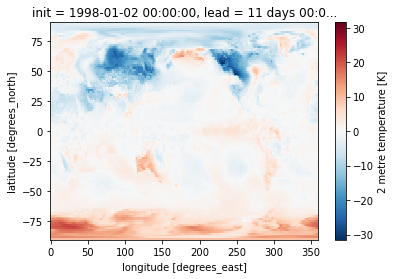

In [10]:
ds_anom.t2m.isel(init=0, lead=10, member=3).plot()